# **Podcast Listening Analysis & Recommendation**


---
 A project to analyze users' podcast listening behavior, uncover listening patterns, and recommend new episodes based on their preferences and episode popularity




---


## Section 1: Setup Environment


In [71]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from IPython.display import display

# For cosine-similarity recommendations
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix



---


##  Section 2: Data Loading

In [56]:
# Define file paths for users, episodes, and listen records
users_path = '/content/users.csv'
episodes_path = '/content/episodes.csv'
listens_path = '/content/listens.json'

# Load user data from CSV into a DataFrame
df_users = pd.read_csv(users_path)

# Load episode data from CSV into a DataFrame
df_episodes = pd.read_csv(episodes_path)

# Open the JSON file containing listen records and normalize into a DataFrame
with open(listens_path, 'r') as f:
    listens = (
        pd.json_normalize(json.load(f))  # Flatten nested JSON structure into columns
        .rename(columns={'duration_seconds': 'listen_duration'})  # Rename for consistency
    )

# Display the first five rows of each DataFrame to verify successful loading
df_users.head()
df_episodes.head()
listens.head()

,user_id,episode_id,listen_duration
0,16,30,60
1,6,8,120
2,6,13,60
3,6,27,1500
4,17,9,1500




---

## Section 3: Data Cleaning

In [33]:
# Combine missing value counts for users, episodes, and listens into one DataFrame
missing_df = pd.concat([
    df_users.isna().sum(),
    df_episodes.isna().sum(),
    listens.isna().sum()
], axis=1)
missing_df.columns = ['users_missing', 'episodes_missing', 'listens_missing']

# Define styling function to color each column differently
def highlight_cols(col):
    colors = {
        'users_missing': '#A52A2A',    # brown
        'episodes_missing': '#FFA500', # orange
        'listens_missing': '#808080'   # gray
    }
    return [f"background-color: {colors[col.name]}" for _ in col]

# Apply the styles and render the table
styled = missing_df.style.apply(highlight_cols, axis=0)
display(styled)

# Treat NaN as zero and sum up all missing values
total_missing = missing_df.fillna(0).values.sum()

# Output a clear message about the presence or absence of missing data
if total_missing == 0:
    print("\nGreat! There are no missing values in users, episodes, or listens.")
else:
    print(f"\nThere are {int(total_missing)} missing values in total.")


,users_missing,episodes_missing,listens_missing
user_id,0.000000,nan,0.000000
age,0.000000,nan,nan
gender,0.000000,nan,nan
country,0.000000,nan,nan
episode_id,nan,0.000000,0.000000
title,nan,0.000000,nan
category,nan,0.000000,nan
listen_duration,nan,nan,0.000000



Great! There are no missing values in users, episodes, or listens.




---

## Section 4: Data Integration

In [4]:
# Merge listen records with user and episode info
df_full = (
    listens
    .merge(df_users, on='user_id', how='inner')
    .merge(df_episodes, on='episode_id', how='inner')
)
# Preview the merged DataFrame
df_full.head()

,user_id,episode_id,listen_duration,age,gender,country,title,category
0,16,30,60,24,female,Saudi Arabia,Episode 30,Sports
1,6,8,120,59,male,Morocco,Episode 8,Sports
2,6,13,60,59,male,Morocco,Episode 13,Society
3,6,27,1500,59,male,Morocco,Episode 27,News
4,17,9,1500,21,male,Saudi Arabia,Episode 9,Sports




---

## Section 5: Exploratory Data Analysis

### 5.1: Plot distribution of listens by category





<ipython-input-67-6f7f5f571248>:9: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




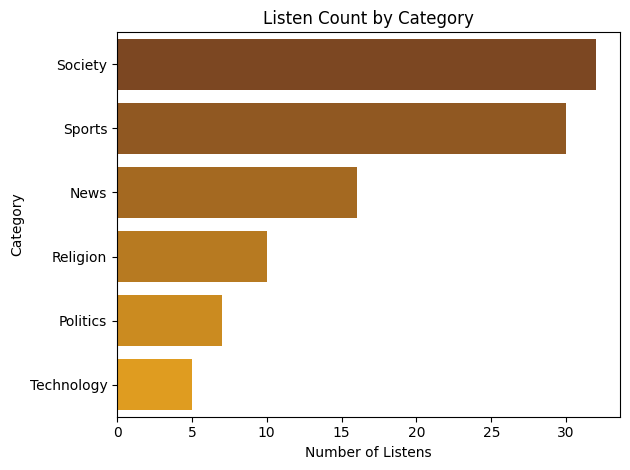

In [67]:
def plot_category_distribution(df):
    # 1. Count listens per category
    category_counts = df['category'].value_counts()

    palette = sns.blend_palette(["#8B4513", "#FFA500"], n_colors=len(category_counts))

    # 2. Plot the counts using that gradient
    sns.barplot(
        x=category_counts.values,
        y=category_counts.index,
        palette=palette
    )

    # 3. Add labels and title
    plt.title('Listen Count by Category')
    plt.xlabel('Number of Listens')
    plt.ylabel('Category')

    # 4. Optimize layout and display
    plt.tight_layout()
    plt.show()

plot_category_distribution(df_full)


**This chart illustrates:**

* The “Society” category tops the list with about 32 listens, followed by “Sports” at around 30 listens, indicating that social and sports content draw the largest audience.

* Listens then drop sharply to “News” (~16), roughly half what the top two achieve, suggesting that news is important but doesn’t command the same level of engagement.

* At the bottom are “Religion” (~10), “Politics” (~7), and finally “Technology” (~5), highlighting an opportunity to create more engaging content for these lower-performing categories.



---


### 5.2: Plot average listen duration by gender


---



<ipython-input-39-278dd69a4336>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


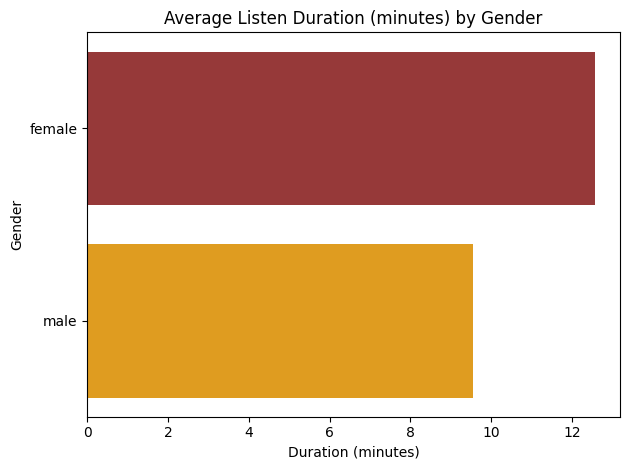

,Avg Duration (min)
female,12.57
male,9.55
Difference (female - male),3.01


In [39]:
# Compute averages in minutes
duration_by_gender_min = df_full.groupby('gender')['listen_duration'].mean() / 60

# Calculate the difference between female and male
diff_gender_min = duration_by_gender_min.get('female', 0) - duration_by_gender_min.get('male', 0)

# Plot average durations by gender
plt.figure()
sns.barplot(
    x=duration_by_gender_min.sort_values(ascending=False).values,
    y=duration_by_gender_min.sort_values(ascending=False).index,
    palette=['#A52A2A', '#FFA500']
)
plt.title('Average Listen Duration (minutes) by Gender')
plt.xlabel('Duration (minutes)')
plt.ylabel('Gender')
plt.tight_layout()
plt.show()

# Build and display results table
stats_df = duration_by_gender_min.to_frame(name='Avg Duration (min)')
stats_df.loc['Difference (female - male)'] = diff_gender_min
stats_df.index.name = None
stats_df.columns = ['Avg Duration (min)']

display(
    stats_df.style
        .format('{:.2f}')
        .set_caption("Average Listen Duration by Gender")
        .set_table_styles([
            {'selector': 'th', 'props': [
                ('background-color', '#f2f2f2'),
                ('text-align', 'center'),
                ('font-weight', 'bold')
            ]},
            {'selector': 'td', 'props': [
                ('text-align', 'center'),
                ('padding', '4px 8px')
            ]}
        ])
)


**Key Findings**
* Average listen duration for females: 12.57 min
* Average listen duration for males: 9.55 min
* Difference: 3.01 min, ~31.6% higher for females

**Analysis & Recommendations**
* Females show stronger engagement with longer episodes.
* To boost male engagement: use shorter episode lengths or more compelling introductions tailored to their listening patterns.



---


### 5.3: Compute and plot average number of unique episodes per user


---



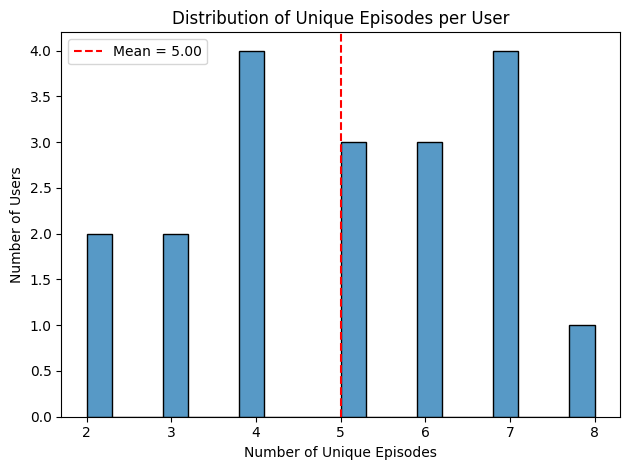


 Average number of unique episodes per user: 5.00



In [47]:
# Count the number of distinct episodes watched per user
episodes_per_user = df_full.groupby('user_id')['episode_id'].nunique()

# Compute the average across all users
average_episodes = episodes_per_user.mean()

# Create histogram of the episode counts
plt.figure()
sns.histplot(episodes_per_user, bins=20)
plt.axvline(average_episodes, color='red', linestyle='--',
            label=f'Mean = {average_episodes:.2f}')
plt.title('Distribution of Unique Episodes per User')
plt.xlabel('Number of Unique Episodes')
plt.ylabel('Number of Users')
plt.legend()
plt.tight_layout()
plt.show()

# Print the computed average
print(f"\n Average number of unique episodes per user: {average_episodes:.2f}\n")

**This chart is a histogram showing the distribution of unique episodes listened to by each user, with a dashed red vertical line marking the mean (5 episodes).**

**Brief Analysis**

* Most users cluster around 4 to 7 episodes, with peaks at 4 and 7.

* The overall average is 5 episodes per user.

* Only a few users listened to fewer than 3 or more than 8 episodes.

* This suggests that typical listeners consume about 5 unique episodes; to boost engagement, consider targeted campaigns—especially for the less active segment—to raise this number.



---


### 5.4: Compute average category diversity per user


---



In [8]:
categories_per_user = df_full.groupby('user_id')['category'].nunique()
print(f"Average category diversity per user: {categories_per_user.mean():.2f}\n")

Average category diversity per user: 3.37



**This metric measures the average number of categories each user listens to, indicating the breadth of their content interests.**



---


### 5.5: Analyze average listen duration by age group


---



<ipython-input-68-7742340be180>:7: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

<ipython-input-68-7742340be180>:13: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




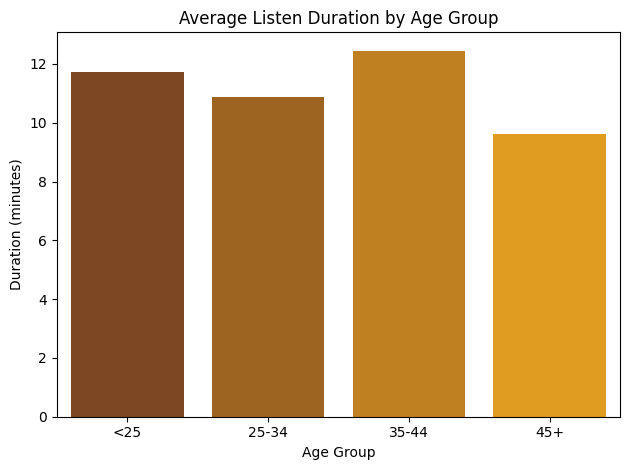

,Age Group,Avg Duration (min)
0,<25,11.72
1,25-34,10.88
2,35-44,12.45
3,45+,9.62


In [68]:
# Define age groups
age_bins = [0, 25, 35, 45, 100]
age_labels = ['<25', '25-34', '35-44', '45+']
df_full['age_group'] = pd.cut(df_full['age'], bins=age_bins, labels=age_labels, right=False)

# Compute average listen duration by age group (in minutes)
duration_by_age_min = df_full.groupby('age_group')['listen_duration'].mean() / 60

plt.figure()
palette = sns.blend_palette(["#8B4513", "#FFA500"], n_colors=len(duration_by_age_min))

sns.barplot(
    x=duration_by_age_min.index,
    y=duration_by_age_min.values,
    palette=palette
)
plt.title('Average Listen Duration by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Duration (minutes)')
plt.tight_layout()
plt.show()


stats_df = duration_by_age_min.to_frame(name='Avg Duration (min)')
stats_df.index.name = 'Age Group'
stats_df = stats_df.reset_index()

display(
    stats_df.style
        .format({'Avg Duration (min)': '{:.2f}'})
        .set_caption("Average Listen Duration by Age Group")
        .set_table_styles([
            {'selector': 'th', 'props': [
                ('background-color', '#f2f2f2'),
                ('text-align', 'center'),
                ('font-weight', 'bold')
            ]},
            {'selector': 'td', 'props': [
                ('text-align', 'center'),
                ('padding', '4px 8px')
            ]}
        ])
)


**It presents the average listen duration (in minutes) for four age groups: <25, 25–34, 35–44, and 45+.**

**Brief Analysis**

* 35–44: Sip your episodes like a fine brew, committing over 12 minutes—they crave rich, in-depth material.

* <25: Maintain strong interest (~11.7 min), driven by curiosity.

* 25–34: Dip slightly (~10.9 min) as life’s demands compete for attention.

* 45+: Consider punchy intros or bite-sized formats (~9.6 min) to keep them tuned in.












---


### 5.6: Listen Concentration Among Users (Lorenz Curve & Gini Coefficient)


---



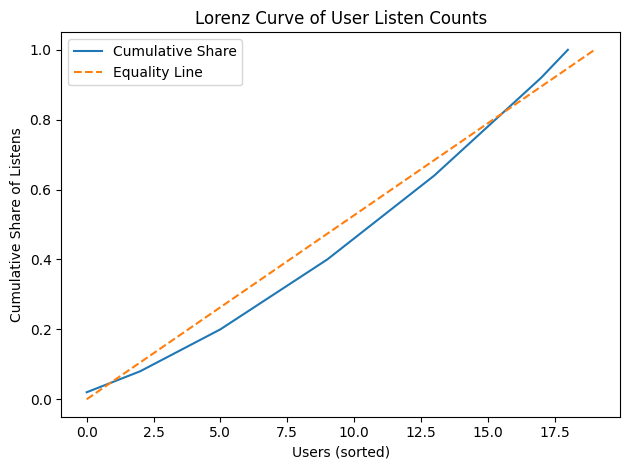


 Gini Coefficient of listen distribution: 0.169


In [49]:
# Aggregate listen counts per user and sort ascending
listen_counts = df_full.groupby('user_id').size().sort_values()

# Compute cumulative sum of listen counts
cum_counts = listen_counts.cumsum()

# Convert cumulative counts to share of total listens
cum_share = cum_counts / listen_counts.sum()
cum_share.index = range(1, len(cum_share) + 1)

# Plot Lorenz curve for listen distribution
plt.figure()
plt.plot(cum_share.values, label='Cumulative Share')
plt.plot([0, len(cum_share)], [0, 1], linestyle='--', label='Equality Line')
plt.title('Lorenz Curve of User Listen Counts')
plt.xlabel('Users (sorted)')
plt.ylabel('Cumulative Share of Listens')
plt.legend()
plt.tight_layout()
plt.show()

# Calculate Gini coefficient from Lorenz curve
gini = 1 - 2 * (cum_share.sum() - cum_share.iloc[-1]/2) / len(cum_share)
print(f"\n Gini Coefficient of listen distribution: {gini:.3f}")     # output final Gini


**The Lorenz Curve and Gini Coefficient give a precise measure of inequality in users’ listen counts. This allows us to:**

* Identify highly active “heavy” listeners versus the less active users.

* Design targeted engagement strategies for each segment (e.g., special campaigns for lighter listeners).

* Monitor how changes (new content, marketing efforts) affect the distribution of listening over time.


**Brief Analysis**

* The curve bows below the equality line, indicating some users consume disproportionately more episodes.

* A Gini Coefficient of 0.169 denotes relatively moderate inequality—listening is fairly balanced with a slight tilt toward concentration.

* Conclusion: While most users listen regularly, a small group of heavy listeners emerges (worth monitoring to prevent content monopolization), and there’s opportunity to boost engagement among lighter users.



---

## Section 6: Recommendation Engine



---


### 6.1: Popularity-Based Recommendations


---



In [59]:
def recommend_episodes(user_id: int,
                       data: pd.DataFrame,
                       episodes: pd.DataFrame,
                       top_n: int = 5) -> pd.DataFrame:
    # User listening history
    user_history = data[data['user_id'] == user_id]

    # Favorite categories sorted by listen count
    favorite_categories = user_history['category'].value_counts().index.tolist()

    # Global popularity counts
    popularity_counts = data['episode_id'].value_counts()

    # Candidate episodes in favorite categories
    candidates = episodes[episodes['category'].isin(favorite_categories)].copy()
    candidates['popularity'] = (
        candidates['episode_id']
                  .map(popularity_counts)
                  .fillna(0)
                  .astype(int)
    )

    # Exclude already listened episodes
    listened_set = set(user_history['episode_id'])
    candidates = candidates[~candidates['episode_id'].isin(listened_set)]

    # Select top_n by popularity
    recommendations = candidates.sort_values('popularity', ascending=False).head(top_n)
    return recommendations[['episode_id', 'title', 'category', 'popularity']]

# Example usage with user ID
user_id = 6
rec_df = recommend_episodes(user_id, df_full, df_episodes, top_n=3)
print(f"Recommendations for user {user_id}:\n")

def highlight_recs(col):
    colors = {
        'episode_id': '#A52A2A',
        'title':      '#FFA500',
        'category':   '#808080',
        'popularity': '#808080'
    }
    return [f"background-color: {colors[col.name]}" for _ in col]

display(rec_df.style.apply(highlight_recs, axis=0))


Recommendations for user 6:



,episode_id,title,category,popularity
5,6,Episode 6,Society,7
28,29,Episode 29,Sports,6
21,22,Episode 22,Society,5


**This table shows the top 3 episode recommendations for user #6 based on their favorite categories and episode popularity:**

* Episode 6 (Society, popularity 7): The most appealing recommendation, belonging to the user’s top “Society” category.

* Episode 29 (Sports, popularity 6): Ranked second, confirming the user’s strong interest in sports content.

* Episode 22 (Society, popularity 5): Another “Society” episode with solid popularity.



---
### 6.2: Cosine Similarity–based Recommendations


---




In [70]:
# Build a user–item listen count matrix and convert to sparse format
user_item = df_full.pivot_table(
    index='user_id',
    columns='episode_id',
    values='listen_duration',
    aggfunc='count',
    fill_value=0
)
user_item_sparse = csr_matrix(user_item.values)

# Compute cosine similarity between every pair of episodes
episode_similarity = cosine_similarity(user_item_sparse.T)
sim_df = pd.DataFrame(
    episode_similarity,
    index=user_item.columns,
    columns=user_item.columns
)

# Function to recommend the top_n most similar episodes to a given episode
def recommend_similar_episodes(episode_id: int,
                               sim_df: pd.DataFrame,
                               top_n: int = 5) -> list:
    if episode_id not in sim_df.index:
        sample_ids = list(sim_df.index[:10])
        raise ValueError(
            f"Episode ID {episode_id} not found. Example IDs: {sample_ids}"
        )
    sims = sim_df.loc[episode_id].sort_values(ascending=False).drop(labels=[episode_id])
    return sims.head(top_n).index.tolist()

# Example usage: pick a valid episode_id, get similar episodes, and display titles with similarity scores
valid_id = sim_df.index[0]
sim_ids = recommend_similar_episodes(valid_id, sim_df, top_n=5)

similar_df = df_episodes[df_episodes['episode_id'].isin(sim_ids)][['episode_id', 'title']].copy()
similar_df['similarity'] = similar_df['episode_id'].map(lambda x: sim_df.loc[valid_id, x])

# Reorder to match the similarity ranking and show the table
similar_df['order'] = similar_df['episode_id'].apply(lambda x: sim_ids.index(x))
similar_df = similar_df.sort_values('order').drop(columns='order')

display(similar_df.reset_index(drop=True))


,episode_id,title,similarity
0,20,Episode 20,0.816497
1,29,Episode 29,0.577350
2,14,Episode 14,0.408248
3,10,Episode 10,0.353553
4,6,Episode 6,0.353553


**This table shows the top 5 episodes most similar to the reference episode, ranked by cosine similarity (values closer to 1 mean higher similarity):**

* Episode 20 is the closest match (0.82)
* Episode 29 follows (0.58)
* Then Episode 14 (0.41)
* Finally Episodes 10 and 6 (both \~0.35)

So you’d recommend Episode 20 first, then 29, and so on.




---

## Section 7: Persisting Results

In [12]:
# Save full merged data and category summary
df_full.to_csv('full_data.csv', index=False)
category_summary = (
    df_full['category']
    .value_counts()
    .rename_axis('category')
    .reset_index(name='counts')
)
category_summary.to_csv('category_counts.csv', index=False)